In [1]:
from spotLight import spotFA

from spotPython.data.diabetes import Diabetes
from spotPython.light.regression.netlightregression import NetLightRegression
from spotPython.utils.classes import get_removed_attributes_and_base_net

from torch.nn import ReLU
import torch

import numpy as np

import matplotlib.pyplot as plt

/Users/alexanderhinterleitner/miniforge3/envs/spotXAI/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 121314
torch.manual_seed(seed)
np.random.seed(seed)

### Exemplary dictionary with the HP config for a network

In [3]:
example_config = {
    "l1": 64,
    "epochs": 1024,
    "batch_size": 32,
    "act_fn": ReLU(),
    "optimizer": "AdamW",
    "dropout_prob": 0.04938229888019609,
    "lr_mult": 2.3689895017756495,
    "patience": 64,
    "initialization": "Default",
}

### Definition of a pre defined spot model architecture

In [4]:
model = NetLightRegression(**example_config, _L_in=10, _L_out=1, _torchmetric="mean_squared_error")

/Users/alexanderhinterleitner/miniforge3/envs/spotXAI/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'act_fn' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['act_fn'])`.


#### Usage of `get_removed_attributes_and_base_net` to transform the Lightning module to a plain pyTorch module

Hint: The remaining training attributes will be later used for the analyzer. This dictionary includes parameters that are relevant for the training of the model like batch size, epochs, optimizer or loss function

In [5]:
removed_attributes, torch_net = get_removed_attributes_and_base_net(net=model)
removed_attributes

{'_dtype': torch.float32,
 '_metric_attributes': None,
 '_compiler_ctx': None,
 '_torchmetric': 'mean_squared_error',
 '_fabric_optimizers': [],
 '_fabric': None,
 '_example_input_array': tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [6]:
torch_net

NetLightRegression(
  (layers): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.04938229888019609, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.04938229888019609, inplace=False)
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.04938229888019609, inplace=False)
    (9): Linear(in_features=32, out_features=16, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.04938229888019609, inplace=False)
    (12): Linear(in_features=16, out_features=1, bias=True)
  )
)

### Select a data set

In [7]:
dataset = Diabetes(target_type=torch.float)

### Define the analyzer by handing over the generated model, the data set, a train split ratio and the dictionary consisting of the "removed attributes"


In [8]:
analyzer = spotFA(model=torch_net, data=dataset, train_split=0.6, training_attributes=removed_attributes, seed=seed)

#### Train the weights of the model

In [9]:
analyzer.train_model()

epochs 1/1024
epochs 2/1024
epochs 3/1024
epochs 4/1024
epochs 5/1024
epochs 6/1024
epochs 7/1024
epochs 8/1024
epochs 9/1024
epochs 10/1024
epochs 11/1024
epochs 12/1024
epochs 13/1024
epochs 14/1024
epochs 15/1024
epochs 16/1024
epochs 17/1024
epochs 18/1024
epochs 19/1024
epochs 20/1024
epochs 21/1024
epochs 22/1024
epochs 23/1024
epochs 24/1024
epochs 25/1024
epochs 26/1024
epochs 27/1024
epochs 28/1024
epochs 29/1024
epochs 30/1024
epochs 31/1024
epochs 32/1024
epochs 33/1024
epochs 34/1024
epochs 35/1024
epochs 36/1024
epochs 37/1024
epochs 38/1024
epochs 39/1024
epochs 40/1024
epochs 41/1024
epochs 42/1024
epochs 43/1024
epochs 44/1024
epochs 45/1024
epochs 46/1024
epochs 47/1024
epochs 48/1024
epochs 49/1024
epochs 50/1024
epochs 51/1024
epochs 52/1024
epochs 53/1024
epochs 54/1024
epochs 55/1024
epochs 56/1024
epochs 57/1024
epochs 58/1024
epochs 59/1024
epochs 60/1024
epochs 61/1024
epochs 62/1024
epochs 63/1024
epochs 64/1024
epochs 65/1024
epochs 66/1024
epochs 67/1024
epoc

#### Perform the attribution analysis

In [10]:
# baseline = torch.Tensor([[0.1,0.1,0.1,0.2,0.1,0.1,0.1,0.2,0.1, 0.2]])
df = analyzer.get_n_most_sig_features(n_rel=10, attr_method="IntegratedGradients", baseline=None)

In [11]:
df

,Feature Index,IntegratedGradientsAttribution
0,9,1806.188357
1,2,1028.623668
2,10,957.370277
3,1,819.819406
4,4,805.643744
5,3,626.849691
6,5,247.164688
7,7,151.326156
8,8,103.297722
9,6,-3.788243


#### Plot the results

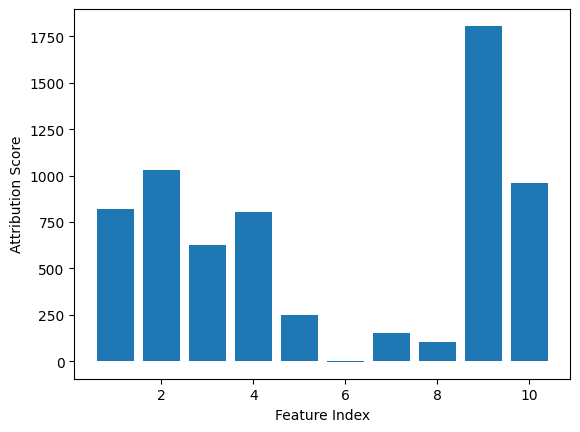

In [12]:
plt.bar(df["Feature Index"], df["IntegratedGradientsAttribution"])
plt.xlabel("Feature Index")
plt.ylabel("Attribution Score")
plt.show()